# ALOHAdielCurveFit: A Jupyter Notebook to fit sinusoidal functions to some of the SCOPE diel data 
Created 12 Apr 2018 by Jamie Collins, james.r.collins@aya.yale.edu
Revision history in GitHub

Some of this code inspired by MATLAB scripts developed for Modeling, Data Analysis and Numerical Techniques for Geochemistry (12.747), a course at MIT

Dependencies: scipy.optimize, numpy, some others

## First, load necessary libraries; let user set working directory

In [1]:
# load libraries
import numpy as np
import csv
import os
import pandas
from datetime import *
import pytz
import pytz_convert
import time
from datetime import timedelta
import iso8601 # so awesome this exists in python; you may need to install it 
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from scipy.optimize import curve_fit

# user set working directory
os.chdir('/Users/jamesrco/Code/DielALOHA/')
print("Working in:",os.getcwd())

Working in: /Users/jamesrco/Code/DielALOHA


## A test

In [2]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

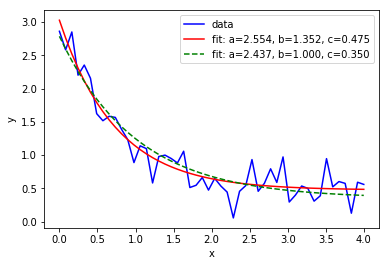

In [3]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata)
popt
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## The real deal

### Load data, take a peek

In [4]:
dielSulfonates_raw = pandas.read_csv('data/sulfonates/sulfonates_BD.csv')
dielSeaFlow_raw = pandas.read_csv('data/seaflow/seaflow_biomassDIEL_jorJamie.csv')

display(dielSulfonates_raw.head(n=10))
display(dielSeaFlow_raw.head(n=10))

,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26T17:11:00-0000,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26T17:11:00-0000,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26T17:11:00-0000,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283
3,7,1000,1,2015-07-26T20:25:00-0000,7.601564,3.198881e+06,315.924313,12.603545,4.005653,209.026833
4,7,1000,2,2015-07-26T20:25:00-0000,4.291812,5.744861e+06,771.503512,31.420815,3.718890,65.651715
5,7,1000,3,2015-07-26T20:25:00-0000,0.592208,4.729765e+06,1527.930893,19.561125,6.248778,51.148806
6,8,1400,1,2015-07-27T00:29:00-0000,7.195938,5.410413e+06,1761.605319,33.739859,4.320685,71.730329
7,8,1400,2,2015-07-27T00:29:00-0000,0.466945,1.021502e+07,5043.952082,55.227529,12.421041,94.619387
8,8,1400,3,2015-07-27T00:29:00-0000,6.103194,4.964977e+06,666.905509,45.784641,2.872352,114.770626
9,11,1800,1,2015-07-27T04:27:00-0000,2.901025,7.968625e+06,2311.339370,49.955310,2.753558,135.176525


,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-25T07:01:00-10:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-25T07:04:00-10:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-25T07:07:00-10:00,1.207168,10.731003,12.954125,1.078549
3,2015-07-25T07:10:00-10:00,1.088433,10.819991,11.776836,0.980529
4,2015-07-25T07:13:00-10:00,1.015561,9.844304,9.997491,0.832382
5,2015-07-25T07:16:00-10:00,1.181247,10.650057,12.580345,1.047428
6,2015-07-25T07:19:00-10:00,1.070121,10.080352,10.787198,0.898132
7,2015-07-25T07:22:00-10:00,0.976476,10.383692,10.139423,0.844199
8,2015-07-25T07:25:00-10:00,1.123217,9.155938,10.284105,0.856245
9,2015-07-25T07:28:00-10:00,1.038736,9.513941,9.882473,0.822806


### Do some data cleaning

In [5]:
dielSulfonates = dielSulfonates_raw.copy()
dielSeaFlow = dielSeaFlow_raw.copy()

# parse and convert dates, ensure all in HST, then store
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates_raw['Timestamp_bottle_closure_GMT_ISO8601'].apply(iso8601.parse_date))
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow_raw['Timestamp_ISO8601'].apply(iso8601.parse_date))
dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow['Timestamp_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

# take a look again at new objects
display(dielSeaFlow.head(n=3))
display(dielSulfonates.head(n=3))

,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-25 07:01:00-10:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-25 07:04:00-10:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-25 07:07:00-10:00,1.207168,10.731003,12.954125,1.078549


,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26 07:11:00-10:00,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26 07:11:00-10:00,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26 07:11:00-10:00,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283


### Analysis
#### Sulfonate data: DHPS

First, let's take a look at a quick plot

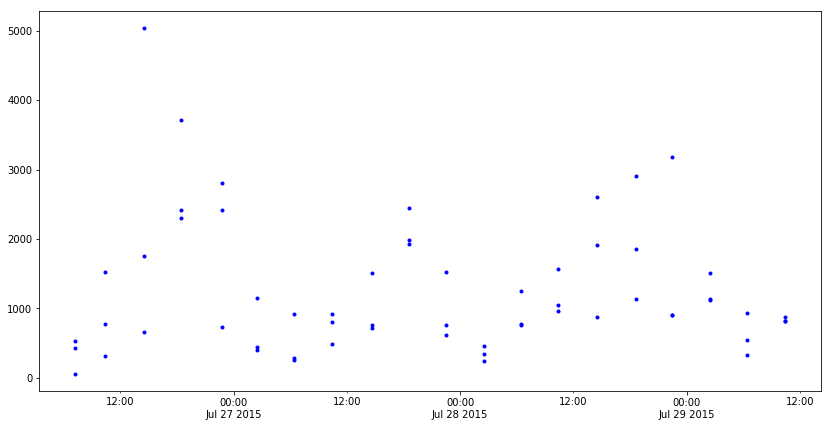

In [6]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['DHPS_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

#ax2 = ax1.twinx()
#ax2.plot(dielSeaFlow['Timestamp_ISO8601'],dielSeaFlow['Cbiomass_umol.L'], 'r-')

#ax2.set_ylim(0.4, 1.8)

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

Before curve fitting, have to excise some NaNs and convert the timestamp field to a different data type

In [7]:
# remove NaNs
xdata_clean = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]
ydata_clean = dielSulfonates['DHPS_pmol.L'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]

# convert time object
print("Starting as:",type(xdata_clean[1]),",",xdata_clean.dtypes)
display(xdata_clean.head(n=3))

xdata_clean = xdata_clean-xdata_clean[1]

print("After converting:",type(xdata_clean[1]),",",xdata_clean.dtypes)
display(xdata_clean.head(n=20))

xdata_clean_alt = (
    xdata_clean.apply(
        lambda x: x.total_seconds()))

print("Or maybe just as second increments:")
display(xdata_clean_alt.head(n=20))

Starting as: <class 'pandas._libs.tslib.Timestamp'> , datetime64[ns, Pacific/Honolulu]


0   2015-07-26 07:11:00-10:00
1   2015-07-26 07:11:00-10:00
2   2015-07-26 07:11:00-10:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: datetime64[ns, Pacific/Honolulu]

After converting: <class 'pandas._libs.tslib.Timedelta'> , timedelta64[ns]


0    00:00:00
1    00:00:00
2    00:00:00
3    03:14:00
4    03:14:00
5    03:14:00
6    07:18:00
7    07:18:00
8    07:18:00
9    11:16:00
10   11:16:00
11   11:16:00
12   15:35:00
13   15:35:00
14   15:35:00
15   19:16:00
16   19:16:00
17   19:16:00
18   23:15:00
19   23:15:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: timedelta64[ns]

Or maybe just as second increments:


0         0.0
1         0.0
2         0.0
3     11640.0
4     11640.0
5     11640.0
6     26280.0
7     26280.0
8     26280.0
9     40560.0
10    40560.0
11    40560.0
12    56100.0
13    56100.0
14    56100.0
15    69360.0
16    69360.0
17    69360.0
18    83700.0
19    83700.0
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: float64

Actually do the fitting

In [8]:
# define our function, assuming data is sinusoidal over three periods

# function where period is kept constant
def multWaves_func_samePer(x, a, b, c, d, e, f, g, h, i):
    return a * (np.cos(2 * np.pi / b * x + c )) + (
        d * (np.cos(2 * np.pi / b * x + e ))) + (
        f * (np.cos(2 * np.pi / b * x + g ))) + h + i * x
# a, d, f: amplitudes
# b: period
# c, e, g: phase
# h: y-offset
# i: slope of linear trend (if any)

# function where period is allowed to vary
def multWaves_func_varPer(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * np.cos(2 * np.pi / b * x + c ) + (
        d * np.cos(2 * np.pi / e * x + f )) + (
        g * np.cos(2 * np.pi / h * x + i )) + j + k * x
# a, d, g: amplitudes
# b, e, h: period
# c, f, i: phase
# j: y-offset
# k: slope of linear trend (if any)


# do the fitting
popt_samePer, pcov_samePer = curve_fit(multWaves_func_samePer, xdata_clean_alt, ydata_clean, bounds=(
    [-100000, 50000, -100000, -100000, -100000, -100000, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 15000, 15000, 15000, 15000, 15000])))
popt_varPer, pcov_varPer = curve_fit(multWaves_func_varPer, xdata_clean_alt, ydata_clean, bounds=(
    [-100000, 50000, -100000, -100000, 50000, -100000, -100000, 50000, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 100000, 15000, 15000, 100000, 15000, 15000, 15000])))

print("Parameter fits for model where length of period (2nd value) is kept constant:")
display(popt_samePer)
print("Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:")
display(popt_varPer)

Parameter fits for model where length of period (2nd value) is kept constant:


array([-5.12354186e+04,  8.66476658e+04, -4.06804039e+04, -5.12347509e+04,
       -4.06782993e+04, -5.13547572e+04, -4.06322395e+04,  1.36255421e+03,
       -3.54094788e-04])

Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:


array([-5.12991751e+04,  8.13391401e+04, -4.06495025e+04, -5.12849875e+04,
        8.14643696e+04, -4.06599463e+04, -5.12722695e+04,  8.13963867e+04,
       -4.06641604e+04,  1.47427025e+03, -1.12124036e-03])

Now, let's take a look at a plot of the data, with the curve fit (varying period length allowed)

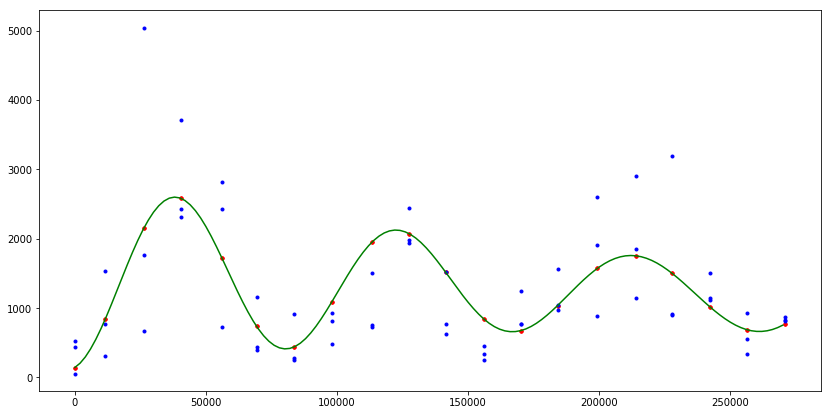

In [9]:
fig = plt.figure(figsize=(14, 7))

plt.plot(xdata_clean_alt, multWaves_func_varPer(xdata_clean_alt, *popt_varPer), 'r.')
plt.plot(xdata_clean_alt, ydata_clean, 'b.')
plt.plot(pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), multWaves_func_varPer(
   pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), *popt_varPer), 'g-')

A plot of the data, with the curve fit (length of period required to be constant)

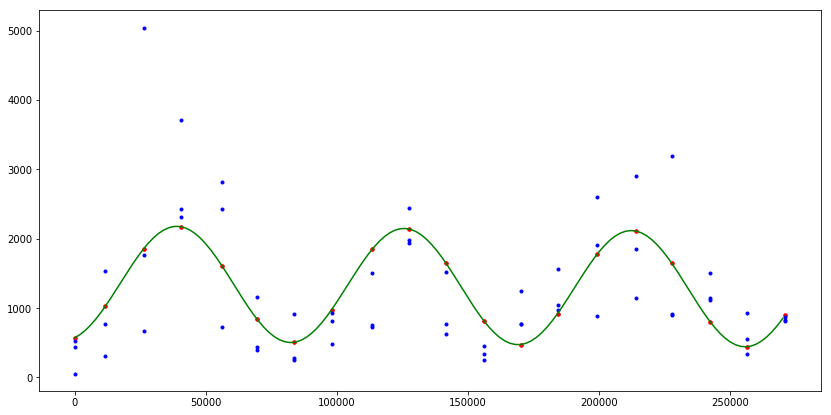

In [10]:
fig = plt.figure(figsize=(14, 7))

plt.plot(xdata_clean_alt, multWaves_func_samePer(xdata_clean_alt, *popt_samePer), 'r.')
plt.plot(xdata_clean_alt, ydata_clean, 'b.')
plt.plot(pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), multWaves_func_samePer(
   pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), *popt_samePer), 'g-')

Look at the two together

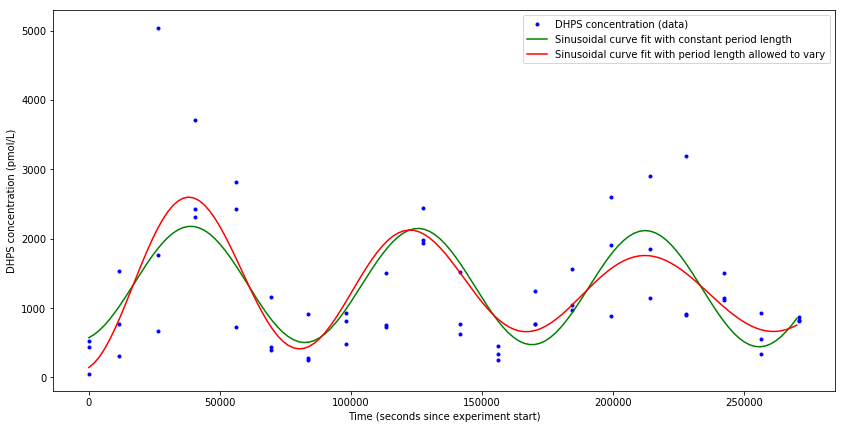

In [12]:
fig = plt.figure(figsize=(14, 7))

plt.plot(xdata_clean_alt, ydata_clean, 'b.', label = 'DHPS concentration (data)')
plt.plot(pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), multWaves_func_samePer(
   pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), *popt_samePer), 'g-', label = 'Sinusoidal curve fit with constant period length')
plt.plot(pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), multWaves_func_varPer(
   pandas.Series(list(range(0, int(xdata_clean_alt[len(xdata_clean_alt)-1]), 2000))), *popt_varPer), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')
plt.ylabel('DHPS concentration (pmol/L)')
plt.legend()
